In [6]:
import pfTent as tent
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


In [7]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['figure.titleweight'] = 'bold'

In [8]:
duration = 500
meroz = 0.01
timeToPeak = 10
maxParasitemia = 5
pgone = -3
n = 10
delta = 1

In [9]:
def growth_rate(p1,p2,k,t1,t2):
    delta_t = t2-t1
    delta_p = p2-p1
    r = (delta_p*k)/(delta_t*p1*(k-p1))
    return r

In [10]:
def get_growth_rate(parasitemia, K,delta):
    rates = []
    length = len(parasitemia)
    for i in np.arange(delta,length,delta):
        p2 = 10**parasitemia[i]
        p1 = 10**parasitemia[i-delta]
        t2 = i
        t1 = i-delta
        k = 10**K
        rate = growth_rate(p1,p2,k,t1,t2)
        rates.append(rate)
    return rates
        


In [11]:
def get_values(immunity=0):
    p = {}
    r = {}
    for i in np.arange(n):
        params = tent.get_infection_params(duration, meroz, timeToPeak, maxParasitemia)
        p[i] = tent.get_parasitemia(params,pgone)
        r[i] = get_growth_rate(p[i], 6,delta)
    return p, r

In [12]:
def plot_growth_rate(parasitemias, rates, title):

    fig, ax = plt.subplots(nrows = 2, figsize=(8,8))
    axins0 = ax[0].inset_axes([0.13,0.2,0.22,0.35])
    axins1 = ax[1].inset_axes([0.4,0.4,0.5,0.5])
    for person in np.arange(n):
        time_p = list(np.arange(len(parasitemias[person])))
        time_r = list(np.arange(delta,len(parasitemias[person]),delta))
        ax[0].plot(time_p, parasitemias[person], linewidth=1.5)
        ax[1].plot(time_r,rates[person],linewidth=1.5)
        axins1.plot(time_r,rates[person],linewidth=1.5)
        axins0.plot(time_p,parasitemias[person],linewidth=1.5)

    ax[0].set_xlabel('Days')
    ax[1].set_xlabel('Days')
    ax[0].set_ylabel('Log10 parasite density')
    ax[1].set_ylabel('Growth rate')
    axins1.set_xlim(0,25)
    axins0.set_xlim(0,25)
    axins0.set_ylim(4,5.5)
    fig.suptitle(title,size=20)
    fig.tight_layout()
    #fig.savefig("figs/r_noImmunity.pdf")

In [13]:
p,r = get_values()

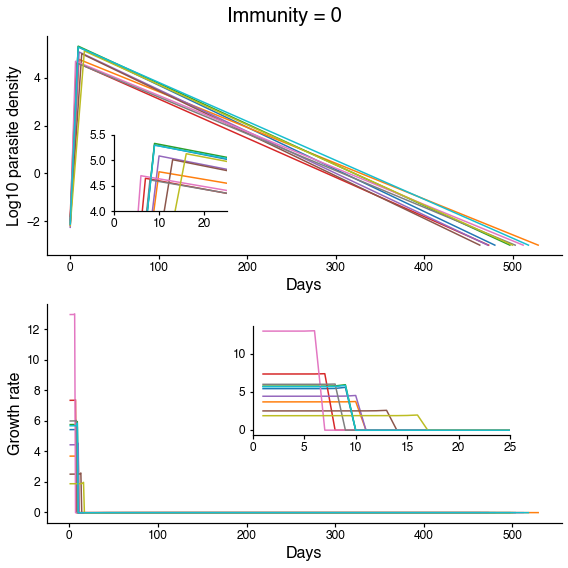

In [14]:
figure = plot_growth_rate(p,r,"Immunity = 0")

In order to see how these quantities vary with different levels of immunity, I need to rewrite how immunity modulates params. Currently, it does so allele by allele, but I can easily change this to calculated total cross immunity and then modulate params.

In [15]:
def modulate_params_NEW(gtype, strain_imm, gen_imm, params, w):
    '''
    Changes all infection params according to immunity:
        gtype = genotype vector for infection
        strain_imm = strain_immunity at time of infection
        gen_imm = general immunity at time of infection.
        params = params vector to modulate
        w = vector modulating immunity effect at locus
    '''
    n_loci = len(gtype)
    cross = np.empty(n_loci)
    for i in np.arange(n_loci):
        allele = gtype[i]
        cross[i] = strain_imm[i,allele]
    imm = np.append(gen_imm, cross)
    
    total_imm = (imm*np.asarray(w)).sum()

    modified = np.zeros(4)
    for i, p in enumerate(params):
        if total_imm == 0 | i == 2: # Immunity doesn't impact time to peak.
            modified[i] = p
        else:
            modified[i] = tent.sigmoid(total_imm, p)
    modified[0] = np.rint(modified[0])
    modified[2] = np.rint(modified[2])
    return modified, total_imm

In [16]:
def modulate_params(gtype, strain_imm, gen_imm, params, w):
    '''
    Changes all infection params according to immunity:
        gtype = genotype vector for infection
        strain_imm = strain_immunity at time of infection
        gen_imm = general immunity at time of infection.
        params = params vector to modulate
        w = vector modulating immunity effect at locus
    '''
    n_loci = len(gtype)
    cross = np.empty(n_loci)
    for i in np.arange(n_loci):
        allele = gtype[i]
        cross[i] = strain_imm[i,allele]
    imm = np.append(gen_imm, cross)
    immu = imm * np.asarray(w)
    immunity = immu.sum()

    M = np.zeros((4, n_loci+1))
    for i, p in enumerate(params):
        for j, v in enumerate(imm):
            if v == 0 | i == 2: # Immunity doesn't impact time to peak.
                M[i,j] = p*w[j]
            else:
                M[i,j] = tent.sigmoid(v, p*w[j])
    modified = np.zeros(4)
    for i in np.arange(4):
        modified[i] = M[i,:].sum()
    modified[0] = np.rint(modified[0])
    modified[2] = np.rint(modified[2])
    return modified, immunity

In [17]:
y=5 # Simulate for 5 years
a = [10,10,10,10] # control,antigenic loci 1, antigenic loci 2, antigenic loci 3
w = [0,0,0.333333,0.3333333,0.333333] # general immunity, control, antigenic loci 1, antigenic loci 2, antigenic loci 3
n_people = 100
fever, breaks = tent.load_data()
gamma = 1/25
delta = 1/250
eir = 40
immune_thresh = 0.01
alpha=1/500
beta=1/500
duration = 500
meroz = .01
timeToPeak = 10
maxParasitemia = 6
pgone=-3

In [18]:
malaria = []
bites = tent.simulate_bites(y,eir)
n_bites = len(bites)
strains = tent.simulate_strains(n_bites,a)
pmatrix = tent.create_allele_matrix(a, y)
smatrix = tent.create_strain_matrix(n_bites,y)
imatrix = tent.create_allele_matrix(a,y)
ivector = tent.create_gen_imm(y)
param_record = np.zeros((4,n_bites,2))
cross_imm = np.zeros((2,n_bites))

for t in range(365*y):
    tent.update_immunity(pmatrix,ivector,imatrix,t,immune_thresh, alpha, beta, gamma, delta)
    treatment_thresh = tent.get_fever_threshold(t,eir,fever,breaks)
    malaria = tent.treat_as_needed(treatment_thresh,pmatrix,smatrix,t,malaria)
    if t in bites:
        if not len(malaria) > 0 or t - malaria[-1] > 7:
            locs = np.where(bites == t)
            for i in locs[0]:
                params = tent.get_infection_params(duration, meroz, timeToPeak, maxParasitemia)
                params_new, immunity = modulate_params(strains[:,i], imatrix[:,:,t], ivector[t], params, w)
                params_alt, immunity_alt = modulate_params_NEW(strains[:,i], imatrix[:,:,t], ivector[t], params, w)
                param_record[:,i,0] = params_new
                param_record[:,i,1] = params_alt
                cross_imm[0,i] = immunity
                cross_imm[1,i] = immunity_alt

                if params_new[0] > 0 and params_new[3] > 0 and params_new[1] > 0.001 and params_new[0] > params_new[2] and params_new[2] > 0:
                    parasitemia = tent.get_parasitemia(params_new, pgone)
                    tent.add_infection(parasitemia,pmatrix,strains[:,i],t,smatrix,i)


/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/pfTent.py:159: RuntimeWarning: divide by zero encountered in double_scalars
  new_param = param/(c/np.tan(np.pi/2*x)**b+1)


In [19]:
param_diff = param_record[:,:,0] - param_record[:,:,1]
immune_diff = cross_imm[0,:] - cross_imm[1,:]

{'bodies': [<matplotlib.collections.PolyCollection at 0x1695a43a0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1692b9910>,
 'cmins': <matplotlib.collections.LineCollection at 0x1695ead90>,
 'cbars': <matplotlib.collections.LineCollection at 0x169604100>}

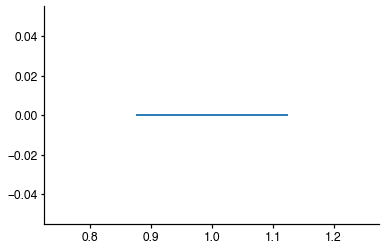

In [20]:
fig,ax = plt.subplots()
ax.violinplot(immune_diff)

So immunity is the same.

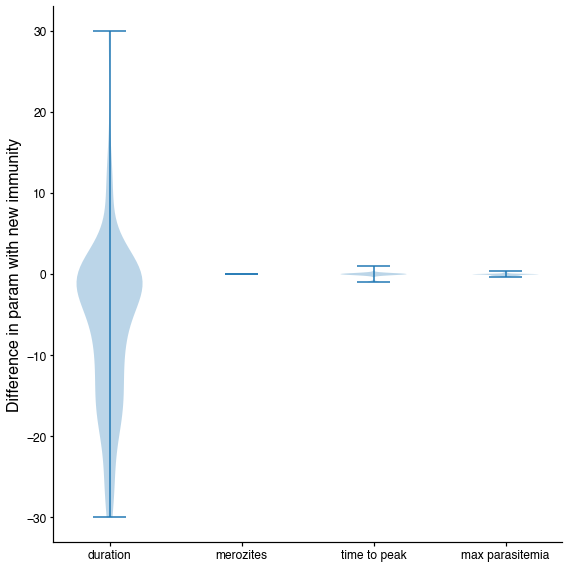

In [21]:
x = ['duration', 'merozites', 'time to peak', 'max parasitemia']
pos = range(1,5)
fig,ax = plt.subplots(figsize = (8,8))
ax.violinplot([param_diff[0,:], param_diff[1,:], param_diff[2,:], param_diff[3,:]],pos)
ax.set_ylabel('Difference in param with new immunity')
ax.set_xticks(pos)
ax.set_xticklabels(x)
fig.tight_layout()

Text(0.5, 0, 'Total immunity')

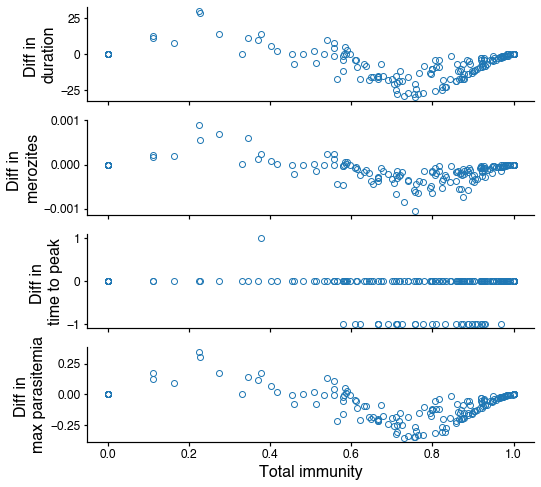

In [22]:
fig,ax = plt.subplots(nrows=4, figsize=(8,8), sharex = True)
for i, lab in zip(range(4), x):
    ax[i].plot(cross_imm[0,:], param_diff[i,:], 'o', mfc='none')
    ax[i].set_ylabel('Diff in \n' + lab)
ax[3].set_xlabel('Total immunity')

At lower immunities, current immunity will result in slightly larger params and at higher immunity, you'll have slightly lower params.

Let's just see how results work with new immunity modulation. If it works, we can just use this to compare how immunity impacts growth rates.

In [23]:
def simulate_person(y,a,w,fever,breaks, eir=40, alpha=1/500, beta=1/500, gamma=1/50, delta=1/500,immune_thresh=0.01,duration = 500, meroz = .01, timeToPeak = 10, maxParasitemia = 6, pgone=-3):
    malaria = []
    bites = tent.simulate_bites(y,eir)
    n_bites = len(bites)
    strains = tent.simulate_strains(n_bites,a)
    pmatrix = tent.create_allele_matrix(a, y)
    smatrix = tent.create_strain_matrix(n_bites,y)
    imatrix = tent.create_allele_matrix(a,y)
    ivector = tent.create_gen_imm(y)
    param_record = np.zeros((4,n_bites,2))
    cross_imm = np.zeros((2,n_bites))

    for t in range(365*y):
        tent.update_immunity(pmatrix,ivector,imatrix,t,immune_thresh, alpha, beta, gamma, delta)
        treatment_thresh = tent.get_fever_threshold(t,eir,fever,breaks)
        malaria = tent.treat_as_needed(treatment_thresh,pmatrix,smatrix,t,malaria)
        if t in bites:
            if not len(malaria) > 0 or t - malaria[-1] > 7:
                locs = np.where(bites == t)
                for i in locs[0]:
                    params = tent.get_infection_params(duration, meroz, timeToPeak, maxParasitemia)
                    params_new, immunity = modulate_params(strains[:,i], imatrix[:,:,t], ivector[t], params, w)
                    params_alt, immunity_alt = modulate_params_NEW(strains[:,i], imatrix[:,:,t], ivector[t], params, w)
                    param_record[:,i,0] = params_new
                    param_record[:,i,1] = params_alt
                    cross_imm[0,i] = immunity
                    cross_imm[1,i] = immunity_alt

                    if params_alt[0] > 0 and params_alt[3] > 0 and params_alt[1] > 0.001 and params_alt[0] > params_alt[2] and params_alt[2] > 0:
                        parasitemia = tent.get_parasitemia(params_alt, pgone)
                        tent.add_infection(parasitemia,pmatrix,strains[:,i],t,smatrix,i)
    return pmatrix, smatrix, imatrix, ivector, malaria, param_record, cross_imm


In [24]:
all_parasites = np.zeros((n_people, len(a), max(a), y*365))
all_strain_immunity = np.zeros((n_people, len(a), max(a), y*365))
all_gen_immunity = np.zeros((n_people,y*365))
all_parasite_density = []
all_infection_lengths = []
all_MOI = []
all_percent_parasitemia = []
all_malaria_rate = []

for person in range(n_people):
    pmatrix, smatrix, imatrix, ivector, malaria, param_record, cross_imm = simulate_person(y,a,w,fever,breaks, gamma=gamma,delta=delta)
    
    Parasitemia, perPositivity = tent.check_parasitemia(3,pmatrix)
    MOI = tent.check_moi(3,smatrix)
    infectionlengths = tent.check_infection_length(smatrix,y,malaria)
    malaria_per_year = len(malaria)/y
    
    all_parasites[person,:,:,:] = pmatrix
    all_strain_immunity[person,:,:,:] = imatrix
    all_gen_immunity[person,:] = ivector
    all_parasite_density.extend(Parasitemia)
    all_infection_lengths.extend(infectionlengths)
    all_MOI.extend(MOI)
    all_percent_parasitemia.append(perPositivity)
    all_malaria_rate.append(malaria_per_year)

/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/pfTent.py:159: RuntimeWarning: divide by zero encountered in double_scalars
  new_param = param/(c/np.tan(np.pi/2*x)**b+1)


In [25]:
all_parasite_density = np.asarray(all_parasite_density)
logPdensity = np.log10(all_parasite_density[all_parasite_density != 0])

Parasite density
min:0.0
max:85559.026057181
median:96.32068999102201
mean:616.7835729152694
std:2490.4854285854535
---------------------
Infection length
min:1
max:364
median:132.0
mean:139.11049508802645
std:66.43322991778739
---------------------
MOI
min:0
max:17
median:8.0
mean:7.4324324324324325
std:4.057429225644029
---------------------
% Parasitemia
min:0.7837837837837838
max:0.972972972972973
median:0.8918918918918919
mean:0.8918918918918919
std:0.03990492718982001
---------------------
Malaria cases per year
min:0.4
max:2.4
median:1.2
mean:1.128
std:0.3388450973527579
---------------------


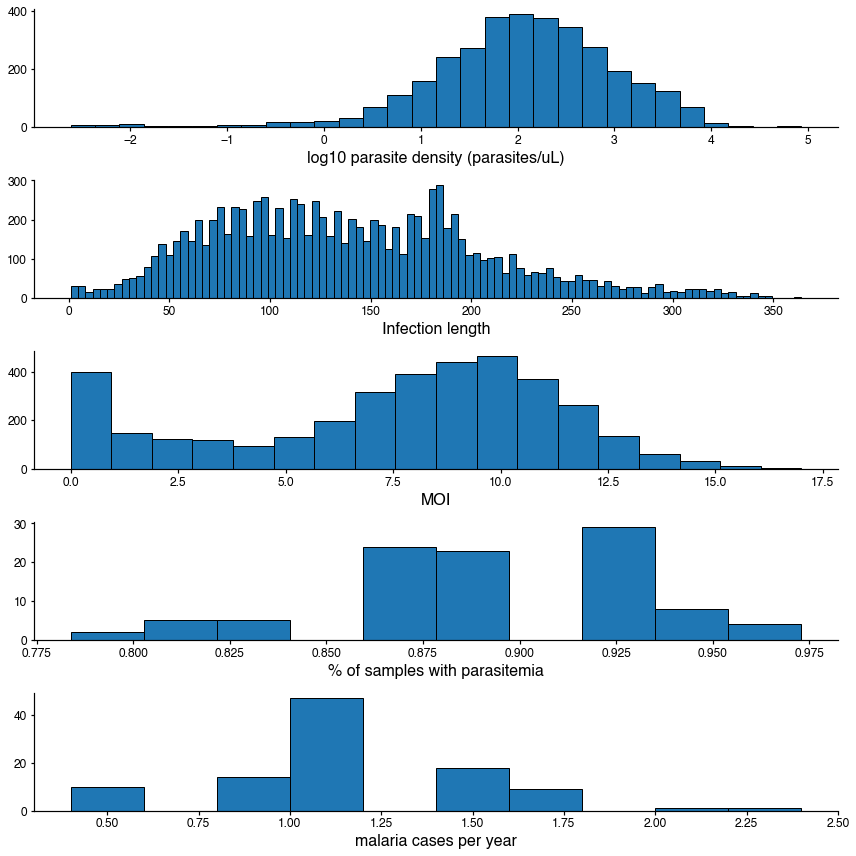

In [26]:
fig,ax = plt.subplots(nrows = 5, tight_layout=True, figsize=(12,12))
ax[0].hist(logPdensity, bins=30, edgecolor = "black")
ax[0].set_xlabel('log10 parasite density (parasites/uL)')
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[1].hist(all_infection_lengths, bins=100, edgecolor = "black")
ax[1].set_xlabel('Infection length')
ax[2].hist(all_MOI, bins=(max(all_MOI)+1), edgecolor = "black")
ax[2].set_xlabel('MOI')
ax[3].hist(all_percent_parasitemia, bins=10, edgecolor = "black")
ax[3].set_xlabel('% of samples with parasitemia')
ax[4].hist(all_malaria_rate, bins=10, edgecolor = "black")
ax[4].set_xlabel('malaria cases per year')

results = [all_parasite_density, all_infection_lengths, all_MOI, all_percent_parasitemia, all_malaria_rate]
labels = ['Parasite density', 'Infection length', 'MOI', '% Parasitemia', 'Malaria cases per year']

for values, l in zip(results, labels):
    print(l)
    print('min:' + str(min(values)))
    print('max:' + str(max(values)))
    print('median:' + str(np.median(values)))
    print('mean:' + str(np.average(values)))
    print('std:' + str(np.std(values)))
    print('---------------------')

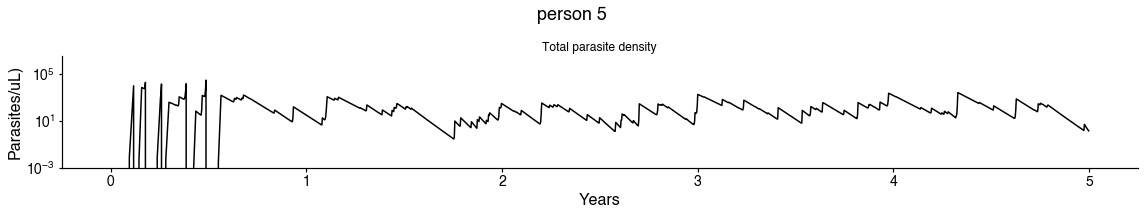

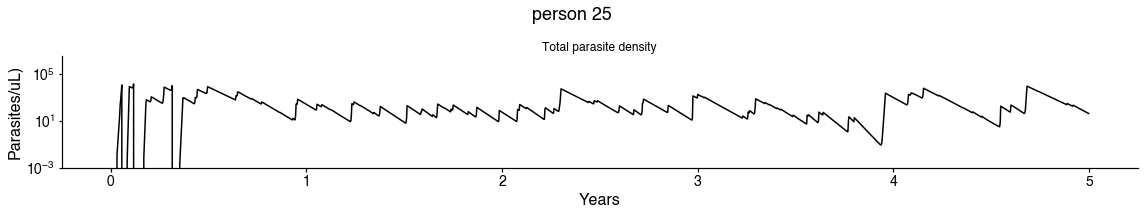

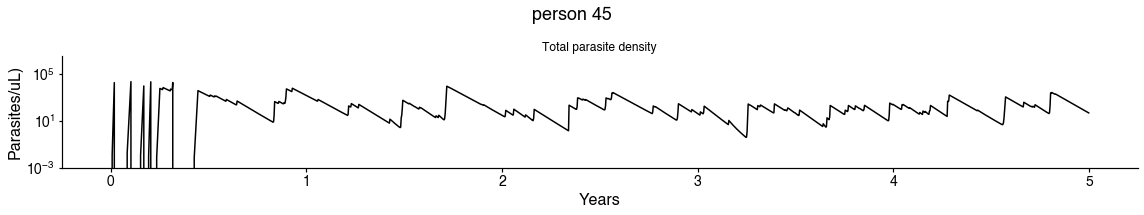

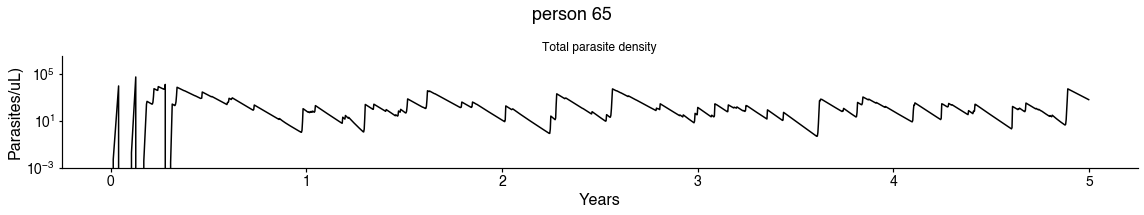

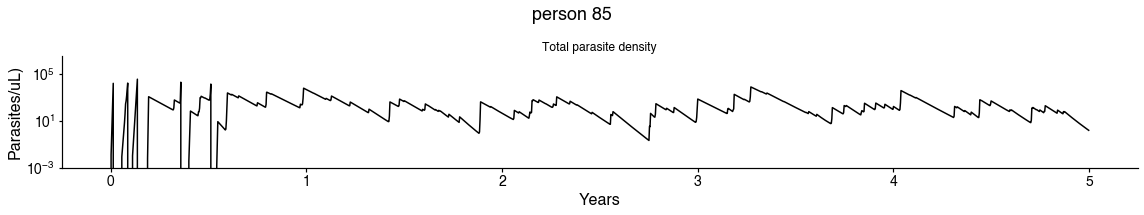

In [27]:
for i in range(5,n_people,20):
    fig, ax = plt.subplots(tight_layout=True, figsize=(16,3))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_yscale('log')
    ax.plot(np.arange(y*365)/365, all_parasites[i,-1,:,:].sum(axis=0),color="black")
    
    ax.set_ylim(0.001,3000000)
    fig.suptitle('person ' + str(i),fontsize=18)
    ax.set_xlabel('Years',fontsize=16)
    ax.set_ylabel('Parasites/uL)',fontsize=16)
    ax.set_title('Total parasite density')

Well, it's not perfect, but considering, I'm just trying to approximate it. I think I'll just go with it.

In [28]:
def modulate_params_simple(imm, params):
    '''
    Changes all infection params according to immunity
    '''
    modified = np.zeros(4)
    for i, p in enumerate(params):
        if imm == 0 | i == 2: # Immunity doesn't impact time to peak.
            modified[i] = p
        else:
            modified[i] = tent.sigmoid(imm, p)
    modified[0] = np.rint(modified[0])
    modified[2] = np.rint(modified[2])
    return modified

def get_values(immunity=0,n=10):
    p = {}
    r = {}
    for i in np.arange(n):
        params = tent.get_infection_params(duration, meroz, timeToPeak, maxParasitemia)
        params = modulate_params_simple(immunity, params)
        p[i] = tent.get_parasitemia(params,pgone)
        r[i] = get_growth_rate(p[i], 6,delta)
    return p, r

In [29]:
def plot_growth_rate(parasitemias, rates, n, title, output=0):

    fig, ax = plt.subplots(nrows = 2, figsize=(8,8))
    #axins0 = ax[0].inset_axes([0.13,0.2,0.22,0.35])
    axins1 = ax[1].inset_axes([0.4,0.4,0.5,0.5])
    for person in np.arange(n):
        time_p = list(np.arange(len(parasitemias[person])))
        time_r = list(np.arange(delta,len(parasitemias[person]),delta))
        ax[0].plot(time_p, parasitemias[person], linewidth=1.5)
        ax[1].plot(time_r,rates[person],linewidth=1.5)
        axins1.plot(time_r,rates[person],linewidth=1.5)
        #axins0.plot(time_p,parasitemias[person],linewidth=1.5)

    ax[0].set_xlabel('Days')
    ax[1].set_xlabel('Days')
    ax[0].set_ylabel('Log10 parasite density')
    ax[1].set_ylabel('Growth rate')
    axins1.set_xlim(0,25)
    #axins0.set_xlim(0,25)
    #axins0.set_ylim(4,5.5)
    fig.suptitle(title,size=20)
    fig.tight_layout()
    if output != 0:
        fig.savefig(output)

In [30]:
p,r = get_values(immunity = 0.25)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
figure = plot_growth_rate(p,r,"Immunity = 0.25", "figs/r_0.25Immunity.pdf")

In [ ]:
p,r = get_values(immunity = 0.5)

In [ ]:
figure = plot_growth_rate(p,r,"Immunity = 0.5", "figs/r_0.5Immunity.pdf")

In [ ]:
p,r = get_values(immunity = 0.75)

In [ ]:
figure = plot_growth_rate(p,r,"Immunity = 0.75", "figs/r_0.75Immunity.pdf")

In [ ]:
p,r = get_values(immunity = 0.95)

In [ ]:
figure = plot_growth_rate(p,r,"Immunity = 0.95", "figs/r_0.95Immunity.pdf")

In [ ]:
p = {}
imm_levels = [0, 0.25, 0.5, 0.75, 0.95]
for imm in imm_levels:
    params = tent.get_infection_params(duration, meroz, timeToPeak, maxParasitemia)
    params = modulate_params_simple(imm, params)
    p[imm] = tent.get_parasitemia(params,pgone)

In [ ]:
imm_levels = [0]
fig, ax = plt.subplots(figsize=(8,4))
for imm in imm_levels:
    time_p = list(np.arange(len(p[imm])))
    ax.plot(time_p, p[imm], linewidth=3, label = imm)

ax.set_xlabel('Days')
ax.set_ylabel('Log10 parasite density')
ax.legend(title="Immunity", fontsize=14, title_fontsize=14)
ax.set_ylim(-3,5)
fig.tight_layout()
fig.savefig("figs/pdensity-0-immunity.pdf")

## Parametrizing parasite densities by growth rates
So I think I can just shift the sigmoid to work for this scenario. Let's see how it goes.

Text(0, 0.5, 'Growth rate')

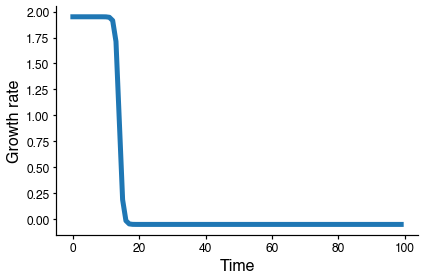

In [31]:
peakTime = 14
def growth_rate(t,start=2,end=-0.05,peakTime=14,slope=-2):
    y = -start/(1+np.exp(slope*(t-peakTime)))
    r = y + start + end
    return r

inputs = np.arange(0,100, 1)
sigmoids = np.asarray([growth_rate(i) for i in inputs])

fig, ax = plt.subplots(tight_layout = True)

ax.plot(inputs, sigmoids, linewidth=5)
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Growth rate",fontsize=16)

In [ ]:
sigmoids[99]

In [32]:
def get_parasite_density(mz,r0,r1, gone=-3,k=5*10**5):
    pdens = []
    rates = []
    p = mz
    t = 0
    pgone = -25
    while p >= 10**pgone:
        pdens.append(p)
        r = growth_rate(t,r0)
        if r > 0:
            p = k/(1+((k-p)/p)*np.exp(-r))
        else:
            pgone = gone
            p = p*np.exp(r)
        t += 1
        rates.append(r)
    return pdens, rates

In [33]:
parasitemias, rates = get_parasite_density(0.01, 2,-0.05)

In [34]:
def graph(parasitemis,rates):
    fig, ax = plt.subplots(nrows = 2, figsize=(8,8))
    time_p = list(np.arange(len(parasitemias)))
    time_r = list(np.arange(len(rates)))
    ax[0].plot(time_p, np.log10(parasitemias), linewidth=1.5)
    ax[1].plot(time_r,rates,linewidth=1.5)
    ax[0].set_xlabel('Days')
    ax[1].set_xlabel('Days')
    ax[0].set_ylabel('Log10 parasite density')
    ax[1].set_ylabel('Growth rate')
    ax[0].set_ylim(-3,6)
    fig.tight_layout()

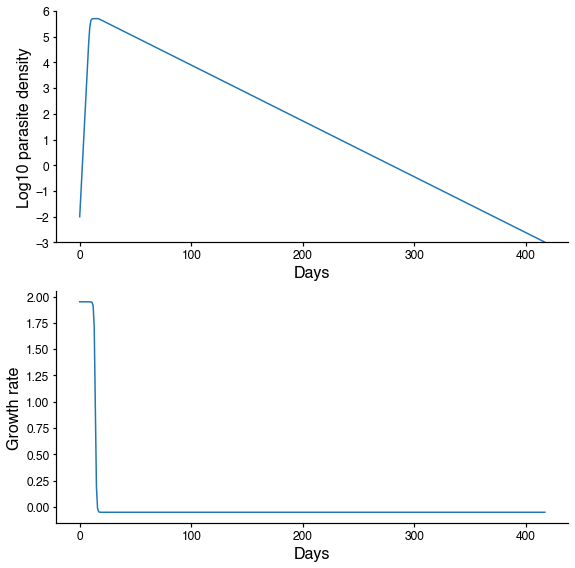

In [35]:
graph(parasitemias,rates)

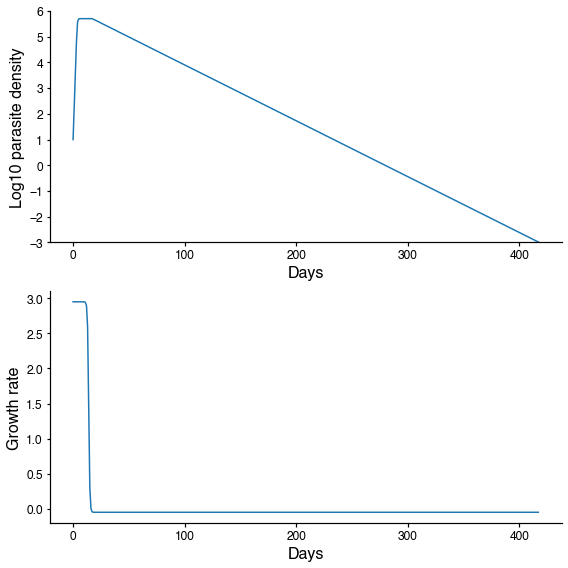

In [36]:
parasitemias, rates = get_parasite_density(10,3,-0.05)
graph(parasitemias,rates)